# ODE  model of NeuroImaging with Bayesian Inference in Stan with cmdstanpy
:::

:post: April 19, 2024
:tags: ODE model with Cmdstanpy
:category: Intermediate, Demo
:author: Nina BALDY, INS, AMU, Marseille.
:acknowledgment: Cyprien DAUTREVAUX and Matthieu GILSON, and Marmadule WOODMAN, and Meysam HASHEMI 

:::

In [1]:
import os
import sys
import time
import errno
import timeit

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
import cmdstanpy

In [3]:
from ERPmodel_JAX import DCM_ERPmodel, odeint_euler, odeint_huen, odeint_rk4
import jax

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
from ERPhelper import *

In [5]:
print(f"Numpy version: {np.__version__}")
print(f"Arviz version: {az.__version__}")
print(f"Cmdstanpy version: {cmdstanpy.__version__}")

Numpy version: 1.26.4
Arviz version: 0.17.0
Cmdstanpy version: 1.1.0


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [8]:
cwd = os.getcwd()
output_dir = cwd + '/output_cmdstanpy/'
! mkdir -p $output_dir

## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference using cmdstanpy interface to Stan's NUTS on a system of ordinary differential equations (ODEs). 

The accuracy and efficiency of different samplers (gradient-free and gradient-based) have been compared in DCM Refs [3,4]. The conclusion is that gradient-free samplers are not powerful enough for this model, and HMC is state-of-the-art for sampling on such high-dimensional models with (nonlinear) correlated parameters. Here we benefit from automatic algorithms and automatic gradient calculation in PPLs such as Stan. Nevertheless, multimodality is omnipresent for such high-dimensional parameters and nonlinear correlated parameters. 
   

### Key Conclusions

We propose solutions for convergence, such as increasing the max_tree_depth and decreasing target_accept_prob, to avoid issues with small step size. Remember that a smaller step size in HMC leads to heavier computational costs.

Importantly, we propose two main solutions to deal with multimodality:

    Initializing at the tail of the prior.

    Weighted stacking of the chains


In this demo, we focus on running the chains with initlization at the tail of prior, to reach convergence for all chains. For the Weighted stacking of the chains, see the advanced notebook name as MultimodalityRemedy.

Refs: 
    

2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


3) https://www.sciencedirect.com/science/article/pii/S1053811915001846


4) https://www.sciencedirect.com/science/article/pii/S1053811915006540

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

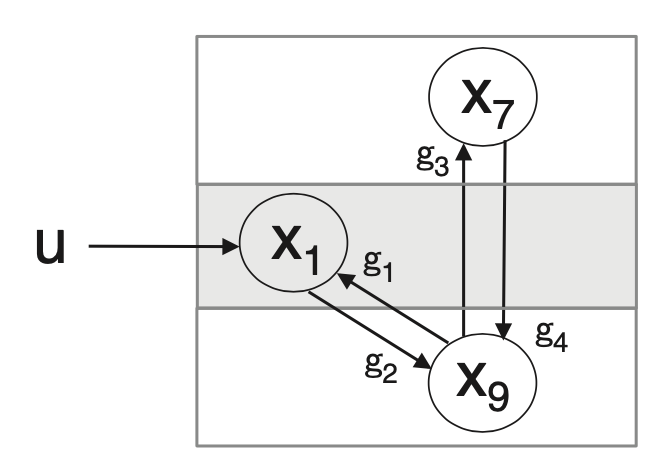

In [9]:
from IPython.display import Image
Image(filename='model.png', width=400) 

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Simulator

In [10]:
rng_key = jax.random.PRNGKey(0)

In [11]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [12]:
ns = 9
x_init=np.zeros((ns))

In [13]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [14]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

Run the model

In [15]:
start_time = time.time()

xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

print("similations took using Euler odeint (sec):" , (time.time() - start_time))

similations took using Euler odeint (sec): 0.10337567329406738


In [16]:
start_time = time.time()

xs_huen = odeint_rk4(DCM_ERPmodel, x_init, ts, theta_true)

print("similations took using Heun odeint (sec):" , (time.time() - start_time))

similations took using Heun odeint (sec): 0.21779656410217285


In [17]:
start_time = time.time()

xs_rk4 = odeint_rk4(DCM_ERPmodel, x_init, ts, theta_true)

print("similations took using RK4 odeint (sec):" , (time.time() - start_time))

similations took using RK4 odeint (sec): 0.2451765537261963


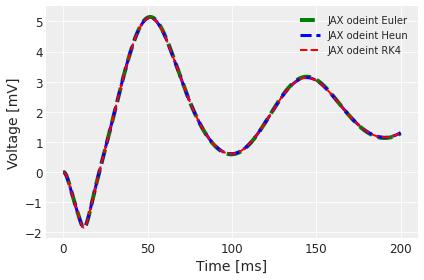

In [18]:
plt.figure(figsize=(6,4))
plt.plot(ts, xs_euler[:,8],'--', color='g', lw=4, label='JAX odeint Euler');
plt.plot(ts, xs_huen[:,8],'--', color='b', lw=3, label='JAX odeint Heun');
plt.plot(ts, xs_rk4[:,8],'--', color='r', lw=2, label='JAX odeint RK4');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
#plt.savefig(os.path.join((output_dir),"Simulators.png"), dpi=800)
plt.show()

So, we use Euler integration, But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [19]:
@jax.jit
def ERP_JAXOdeintSimuator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [20]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("similations with compiling took (sec):" , (time.time() - start_time))

similations with compiling took (sec): 0.08243274688720703


In [21]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("similations using JAX's JIT took (sec):" , (time.time() - start_time))

similations using JAX's JIT took (sec): 0.0009071826934814453


## Synthetic Observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [22]:
#observation noise
sigma_true = 0.1 

In [23]:
xpy_jax = ERP_JAXOdeintSimuator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [24]:
#downsampling
ds=10

In [25]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [26]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [27]:
data = { 'nt': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'ns': ns, 'x_init': x_init,
       'obs_err': sigma_true, 'xpy_obs': np.array(xpy_obs), 'n_params': n_params,
      'alpha': -0.56}

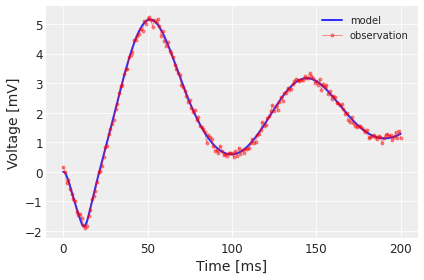

In [28]:
plot_obsrvation(ts, xpy_jax, ts_obs, xpy_obs)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].
The Gamma distribution has two parametrization: numpy.random.gamma uses the shape and scale parametrization, while stan uses the shape and rate.

In [29]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, scale=scale, rate=rate)

In [30]:
data['dt'] = dt * ds
data['prior_gamma_shape'] = prior_specs['shape']
data['prior_gamma_rate'] = prior_specs['rate']

In [31]:
model_name = 'NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior'
stanfile = os.path.join('./stan_models/', model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [32]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    g_1 ~ gamma(prior_gamma_shape[1], prior_gamma_rate[1]);
    g_2 ~ gamma(prior_gamma_shape[2], prior_gamma_rate[2]);
    g_3 ~ gamma(prior_gam

In [33]:
n_= 100 
prior_pred = model.sample(data=data, iter_warmup=1000, iter_sampling=n_)

14:31:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:31:46 - cmdstanpy - INFO - CmdStan done processing.
14:31:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 50, column 4 to column 59)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 50, column 4 to column 59)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Consider re-running with show_console=True if t

In [34]:
prior_pred_samples = prior_pred.stan_variables()

In [35]:
prior_predictions = {'xpy_model': prior_pred_samples['x_hat']}
for key in my_var_names :
    prior_predictions[key] = prior_pred_samples[key]

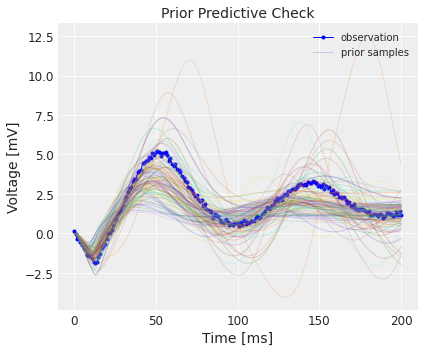

In [36]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title)

## NUTS sampling 

Due to large dimentionality of problem and the nonlinear relation between parameeters, the multimodality is omnipresence in this case. In the follwing , we run 4 NUTS chains with default configurations that operates across diverse problems, but not necessarliy leads to convergence. Then we tune the algorithmic parameetrs for better convergence, however, resulting in multimodality. Finaly, we propose the weighted stacking the chains as a solution to deal with this challenge. 

For this example we run the chains at the tail of prior to get convergence for all chains.

In [37]:
model_name = 'NMM_EPR_Euler_full_ODE_sampling_GammaPrior'
stanfile = os.path.join('./stan_models/', model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [38]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    matrix[ns, nt_full] x;
    vector[ns] dx;
    array[nt] int nt_indexing = linspaced_int_array(nt, 1, nt_full);
    row_vector[nt] x_hat;    


In [39]:
adapt_delta = 0.6
max_treedepth = 10

In [40]:
n_warmup, n_samples, n_chains = 200, 200, 4

In [41]:
#initialize in the tails of the priors
np.random.seed(0)
prior, init_low_prob = low_prob_sample(my_var_names, prior_predictions)   

In [42]:
inits = dict(zip(my_var_names, init_low_prob))

In [43]:
output_fit_dir = output_dir + 'output_hmc_' + model_name

In [44]:
start = time.time()
hmc_fit = model.sample(data=data, iter_warmup=n_warmup, iter_sampling=n_samples, chains=n_chains,
                       output_dir=output_fit_dir ,
                       adapt_delta=adapt_delta, max_treedepth=int(max_treedepth), 
                       inits=inits)
end = time.time()
print(end - start, ' seconds')

12:45:18 - cmdstanpy - INFO - created output directory: /mnt/data/tng/phd/DCM/DCM_ERP_new/output_cmdstanpy/output_hmc_NMM_EPR_Euler_full_ODE_sampling_GammaPrior
12:45:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:55:33 - cmdstanpy - INFO - CmdStan done processing.
12:55:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 56, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/stan_models/NMM_EPR_Euler_full_ODE_sampling_GammaPrior.stan', line 57, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is


615.4674484729767  seconds


In [45]:
az_obj = az.from_cmdstan(output_fit_dir  + '/*.csv')

In [46]:
az.summary(az_obj, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.519,0.118,0.297,0.731,0.004,0.003,843.0,514.0,1.00
g_2,0.655,0.076,0.506,0.794,0.004,0.003,425.0,489.0,1.01
g_3,0.140,0.023,0.102,0.187,0.001,0.001,522.0,488.0,1.01
g_4,0.216,0.033,0.157,0.279,0.001,0.001,692.0,552.0,1.01
delta,12.320,0.380,11.663,13.073,0.020,0.014,346.0,377.0,1.00
tau_i,7.652,0.087,7.495,7.822,0.004,0.003,497.0,520.0,1.00
h_i,19.856,3.411,13.564,26.478,0.118,0.086,852.0,481.0,1.01
tau_e,5.736,0.161,5.451,6.044,0.009,0.006,347.0,400.0,1.00
h_e,1.906,0.223,1.486,2.312,0.011,0.007,426.0,542.0,1.01
u,3.520,0.575,2.587,4.669,0.022,0.015,693.0,614.0,1.00


In [47]:
lp = az_obj.sample_stats['lp'].to_numpy().flatten()
print('Expected log joint density: {:.2f}'.format(lp.mean()))

Expected log joint density: 65.52


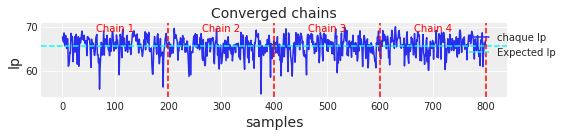

In [48]:
title='Converged chains'
plot_lp_chains(lp, n_chains, title)

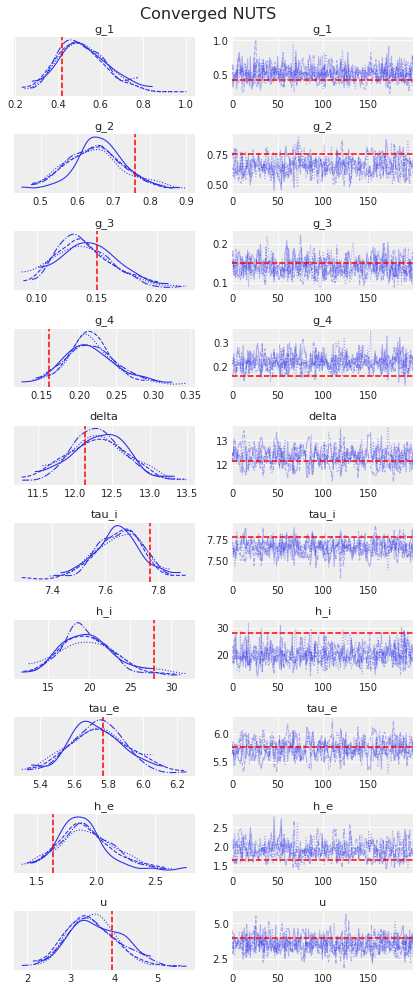

In [49]:
axes = az.plot_trace(
    az_obj,
    var_names=my_var_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')  
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();

In [50]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled = calcula_map(chains_pooled)

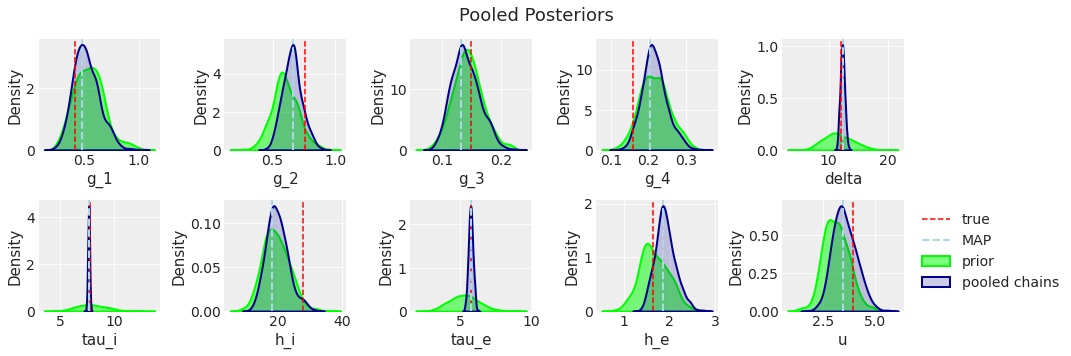

In [51]:
title="Pooled Posteriors"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title)

### Fit and Posterior predictive check 

In [52]:
#to be able to use the plot function, we rename x_hat into xpy_model
az_obj.posterior['xpy_model'] = az_obj.posterior['x_hat']

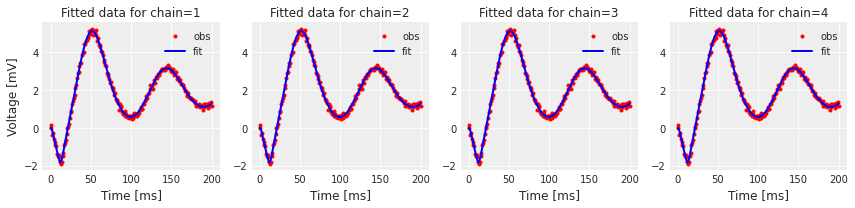

In [53]:
plot_fitted(data, az_obj.posterior)

In [54]:
ppc_= az_obj.posterior['x_hat_ppc']
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=(0, 1))
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=(0, 1))

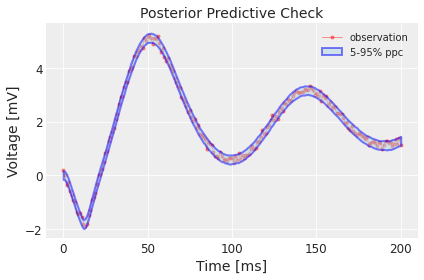

In [55]:
title='Posterior Predictive Check'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title)

In [56]:
#! pip install watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Apr 19 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
arviz     : 0.17.0
matplotlib: 3.5.2
numpy     : 1.26.4
jax       : 0.4.13
seaborn   : 0.13.2
cmdstanpy : 1.1.0

Watermark: 2.4.3

